In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/workspaces/my_dissertation')
from visualizations.scripts.drawer import metric_viewer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import xarray as xr
from tqdm.notebook import tqdm
import glob
from visualizations.scripts.drawer import russia_plots, russia_plots_n
import seaborn as sns
import matplotlib.ticker as ticker
from copy import deepcopy

In [5]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
ws_file = ws_file[ws_file['new_area'] <= 50000]
basemap_data = gpd.read_file(
    '../geo_data/great_db/geometry/russia_forest_25people.geojson')
ugms_shp = gpd.read_file(
    '../geo_data/great_db/geometry/ugms.shp')[['name1', 'geometry']]

### Update geometrty in UGMS based on available gage stations

In [6]:
# sib
srednesib_limit = gpd.read_file(
    '../geo_data/great_db/geometry/srednesib_lim.gpkg')
ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = ['Среднесибирское, ограниченное', ugms_shp.loc[17,
                                                                                                      'geometry'].intersection(srednesib_limit.loc[0, 'geometry'])]
# yakutsk
yakutsk_limit = gpd.read_file(
    '../geo_data/great_db/geometry/yakut_lim.gpkg')
ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = ['Якутское, ограниченное', ugms_shp.loc[23,
                                                                                               'geometry'].intersection(yakutsk_limit.loc[0, 'geometry'])]
# chukotka
chukotka_limit = gpd.read_file(
    '../geo_data/great_db/geometry/chukot_limit.gpkg')
ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = [
    'Чукотское, ограниченное', ugms_shp.loc[22, 'geometry'].intersection(
        chukotka_limit.loc[0, 'geometry'])]
ugms_shp = ugms_shp.reset_index(drop=True)
ugms_shp = ugms_shp.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                             12, 13, 14, 15, 16, 25, 18, 19, 20, 21,
                             27, 26, 24, 17, 23, 22])
ugms_shp.sort_index(inplace=True)

In [16]:
ugms_shp

name1   
0                      Башкирское  \
1                 Верхне-Волжское   
2                 Дальновосточное   
3                   Забайкальское   
4               Западно-Сибирское   
5                       Иркутское   
6                      Камчатское   
7                       Колымское   
8                        Крымское   
9                      Мурманское   
10                  Обь-Иртышское   
11                    Приволжское   
12                     Приморское   
13                    Сахалинское   
14                       Северное   
15                Северо-Западное   
16               Северо-Кавказкое   
17                Среднесибирское   
18                      Татарстан   
19                      Уральское   
20                     Центальное   
21         Центрально-Черноземное   
22                      Чукотское   
23                       Якутское   
24      Черного и Азовского морей   
25  Среднесибирское, ограниченное   
26         Якутское, ограниченное   
27        Чукотское, ограниченное   

                                             geometry  NSE_era5l   NSE_TFT   
0   POLYGON ((53.15754 55.13295, 53.15831 55.13786...   0.610642  0.693607  \
1   MULTIPOLYGON (((53.94598 56.64631, 53.96247 56...   0.494586  0.448670   
2   MULTIPOLYGON (((136.34450 54.68175, 136.34625 ...   0.583843  0.797702   
3   POLYGON ((118.26510 58.39145, 118.26715 58.390...   0.696200  0.828500   
4   POLYGON ((77.23138 60.84556, 77.24359 60.84232...   0.792385  0.831393   
5   POLYGON ((95.64703 54.29784, 95.64770 54.29959...   0.706672  0.772084   
6   MULTIPOLYGON (((157.61792 57.96196, 157.61601 ...   0.735093  0.928674   
7   MULTIPOLYGON (((159.32425 61.80881, 159.32535 ...   0.682709  0.790603   
8   POLYGON ((33.71499 46.21249, 33.72054 46.21249...        NaN       NaN   
9   MULTIPOLYGON (((37.70574 68.69770, 37.70660 68...   0.828047  0.782440   
10  MULTIPOLYGON (((73.42976 73.56414, 73.42962 73...   0.636027  0.784068   
11  POLYGON ((42.20509 53.81865, 42.20719 53.81910...   0.000000  0.402151   
12  MULTIPOLYGON (((131.83016 43.27842, 131.83037 ...   0.507050  0.704229   
13  MULTIPOLYGON (((145.98748 43.36928, 145.98920 ...   0.694782  0.697543   
14  MULTIPOLYGON (((70.93261 66.44458, 70.93245 66...   0.840890  0.699521   
15  MULTIPOLYGON (((36.56601 63.97242, 36.56726 63...   0.699077  0.857800   
16  MULTIPOLYGON (((47.77988 43.98914, 47.80151 43...   0.322113  0.783419   
17  MULTIPOLYGON (((104.64180 72.61425, 104.61915 ...   0.763753  0.764939   
18  MULTIPOLYGON (((47.23702 54.84680, 47.24292 54...   0.000000  0.464879   
19  POLYGON ((52.20274 60.84744, 52.36094 60.82918...   0.732345  0.720742   
20  MULTIPOLYGON (((42.63858 54.55823, 42.64126 54...   0.521836  0.489381   
21  POLYGON ((31.46587 53.20953, 31.47223 53.20636...   0.074735  0.623385   
22  MULTIPOLYGON (((-172.78124 67.04893, -172.7798...   0.689069  0.817008   
23  MULTIPOLYGON (((161.41595 69.22066, 161.41475 ...   0.847668  0.749060   
24  POLYGON ((38.67532 44.48894, 38.67751 44.48909...   0.578740  0.646026   
25  MULTIPOLYGON (((104.60375 61.00403, 104.60366 ...        NaN       NaN   
26  POLYGON ((138.30534 60.43980, 138.30590 60.438...        NaN       NaN   
27  POLYGON ((161.13208 68.15625, 161.13208 68.155...        NaN       NaN   

    NSE_TFT_all   NSE_hbv  NSE_gr4j   NSE_rfr  
0      0.726445  0.261704  0.250307  0.291434  
1      0.637593  0.000000  0.066087  0.000000  
2      0.776136  0.542950  0.623338  0.579798  
3      0.833614  0.412107  0.602351  0.554210  
4      0.817138  0.337213  0.479418  0.568793  
5      0.756991  0.374943  0.542028  0.476413  
6      0.869322  0.016924  0.453214  0.686643  
7      0.804689  0.410479  0.612290  0.668685  
8           NaN       NaN       NaN       NaN  
9      0.646959  0.362888  0.621849  0.610218  
10     0.856456  0.381108  0.401775  0.468851  
11     0.761421  0.000000  0.000000  0.000000  
12     0.744429  0.431066  0.506492  0.380343  
13     0.744135  0.

### CDF for model runs

In [26]:
# random forest regressor
rfr_run, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                 metric_col='NSE',
                                 gauges_file=gauges_file)
# hbv
hbv_run, nse_hbv = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                 metric_col='NSE',
                                 gauges_file=gauges_file)
# gr4j
gr4j_run, nse_gr4j = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                  metric_col='NSE',
                                  gauges_file=gauges_file)
# tft (by gauge)
tft_run, nse_tft_single = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                        metric_col='NSE',
                                        gauges_file=gauges_file)
# tft (all together)
tft_256, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# lstm + static
lstm_era5l, nse_lstm_static = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                            metric_col='NSE',
                                            gauges_file=gauges_file)
# lstm (only meteo)
lstm_no_static, nse_lstm_meteo = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                               metric_col='NSE',
                                               gauges_file=gauges_file)

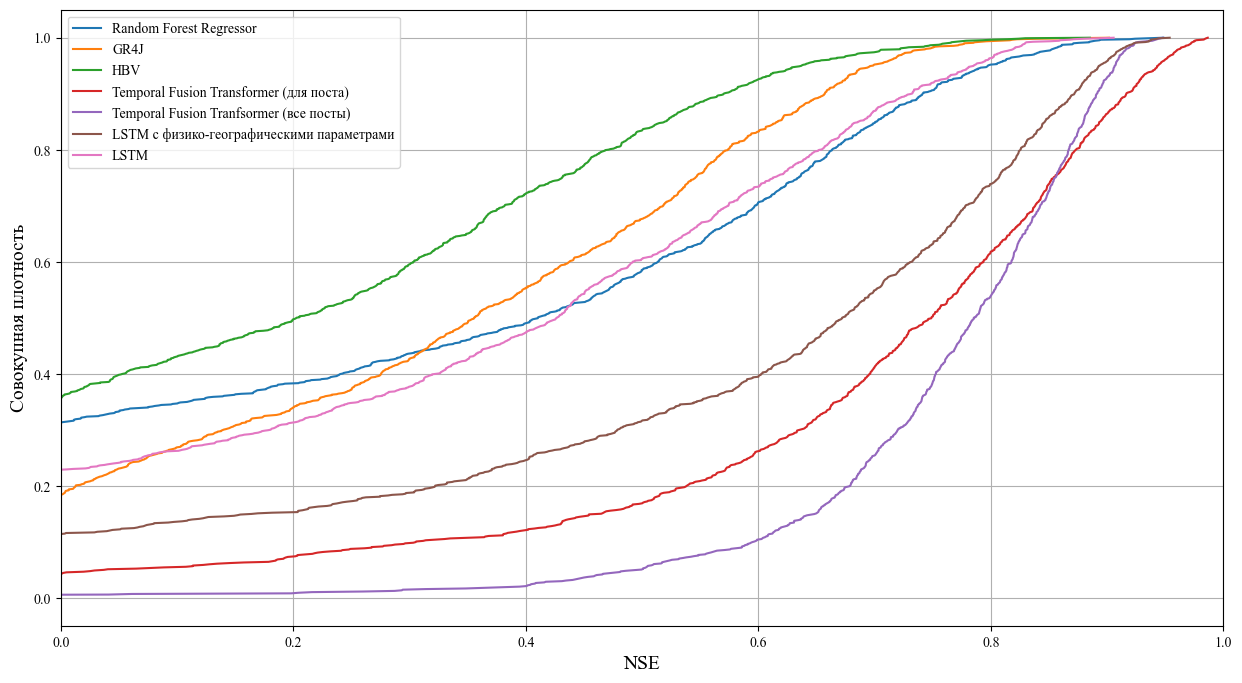

In [33]:
def ecdf(x: np.ndarray):
    """Calculate empirical cummulative density function
    
    Parameters
    ----------
    x : np.ndarray
        Array containing the data
    
    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys


fig, ax = plt.subplots(figsize=(15, 8))

for name, fil in {'Random Forest Regressor': rfr_run['NSE'],
                  'GR4J': gr4j_run['NSE'],
                  'HBV': hbv_run['NSE'],
                  'Temporal Fusion Transformer (для поста)': tft_run['NSE'],
                  'Temporal Fusion Tranfsormer (все посты)': tft_256['NSE'],
                  'LSTM с физико-географическими параметрами': lstm_era5l['NSE'],
                  'LSTM': lstm_no_static['NSE']}.items():
    
    bin_, cdf_ = ecdf(fil.to_numpy())
    plt.plot(bin_, cdf_,
             label=f'{name}');
    ax.set_xlim(0, 1)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xlabel('NSE', fontsize=14)
    ax.set_ylabel('Совокупная плотность', fontsize=14);
fig.savefig('./images/CDF_models.png',
            dpi=650, bbox_inches='tight')

### Best meteo input

In [64]:
def get_r2(df,
           frequency: str,
           prcp_col: str,
           hydro_col: str = 'q_mm_day'):
    df = df.groupby(pd.Grouper(freq=frequency)).sum()
    df = pd.concat([df[prcp_col], df[hydro_col]], axis=1).dropna()
    return pearsonr(x=df[hydro_col], y=df[prcp_col])


res_df = list()
for file in tqdm(glob.glob('../geo_data/great_db/nc_all_q/*.nc')):
    
    gauge_id = file.split('/')[-1][:-3]
    test_df = xr.open_dataset(file)
    test_df = test_df.to_dataframe()[['q_cms_s', 'q_mm_day', 'lvl_sm',
                                      'prcp_e5', 'prcp_e5l',
                                      'prcp_gpcp', 'prcp_imerg',
                                      'prcp_mswep']]

    res_df.append(pd.DataFrame({prcp_col: get_r2(df=test_df,
                                frequency='7D',
                                prcp_col=prcp_col,
                                hydro_col='q_mm_day')[0]
    for prcp_col in ['prcp_e5', 'prcp_e5l',
                     'prcp_gpcp', 'prcp_imerg',
                     'prcp_mswep']},
                               index=[gauge_id]))
res_df = pd.concat(res_df)
res_df.index.name = 'gauge_id'
geom_r2 = gauges_file.set_index('gauge_id').join(res_df).dropna()

A Jupyter Widget

/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient 

In [57]:
def r2_descriptor(r2_df: pd.DataFrame,
                  prcp_col: str,
                  day_range: str):
    res_df = pd.DataFrame()
    res_df.loc[0, 'Сумма за дней:'] = day_range
    res_df.loc[0, 'Источник реанализа'] = prcp_col
    
    res_df.loc[0, 'Объектов в выборке'] = f'{len(r2_df):.0f}'
    
    nse_max = r2_df[prcp_col].max()
    res_df.loc[0, 'Максимальная корреляция'] = f'{nse_max:.2f}'
    
    nse_median = r2_df[prcp_col].median()
    res_df.loc[0, 'Медианная корреляция'] = f'{nse_median:.2f}'
    
    nse_mean = r2_df[prcp_col].mean()
    res_df.loc[0, 'Средняя корреляция'] = f'{nse_mean:.2f}'
    
    nse_min = r2_df[prcp_col].min()
    res_df.loc[0, 'Минимальная корреляция'] = f'{nse_min:.2f}'
    
    nse_less_t_z = (r2_df[prcp_col] < 0).sum()
    res_df.loc[0, 'Корреляция < 0'] = f'{nse_less_t_z:.0f}'
        
    return res_df

In [58]:
r2_1d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_1d.append(r2_descriptor(r2_df=geom_r2, prcp_col=met_col, day_range='1 день'))
r2_1d_df = pd.concat(r2_1d)


In [62]:
r2_30d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_30d.append(r2_descriptor(r2_df=geom_r2, prcp_col=met_col, day_range='30 дней'))
r2_30d_df = pd.concat(r2_30d)

In [66]:
r2_7d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_7d.append(r2_descriptor(r2_df=geom_r2, prcp_col=met_col, day_range='7 дней'))
r2_7d_df = pd.concat(r2_7d)

In [111]:
res_df = pd.concat([r2_1d_df, r2_7d_df, r2_30d_df]).reset_index(drop=True)
test_df = res_df.set_index(['Сумма за дней:', 'Источник реанализа'],
                           append=False)
test_df.to_csv('./results/r2_meteo.csv')

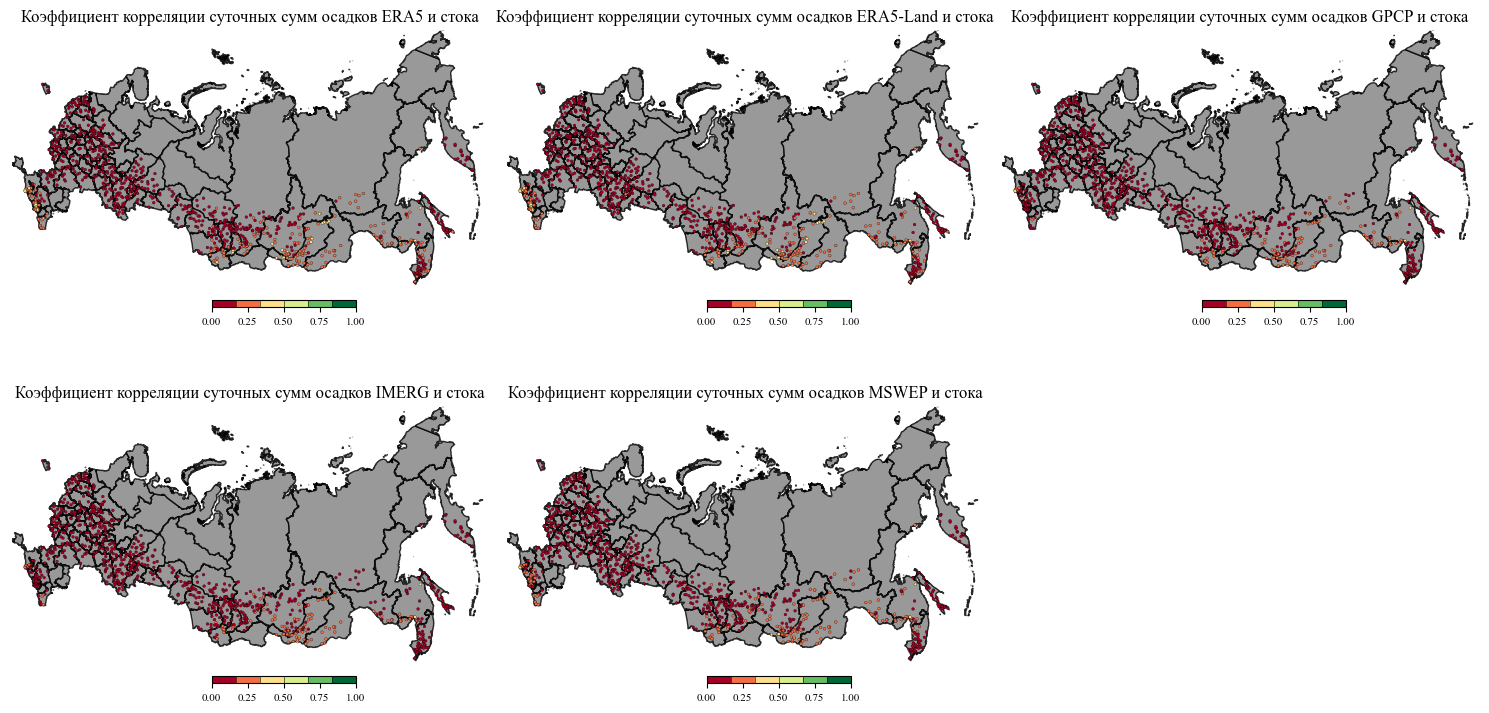

In [38]:
r2_plots = russia_plots_n(
    gdf_to_plot=geom_r2,
    basemap_data=basemap_data,
    cmap_name='RdYlGn',
    figsize=(15, 8),
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                      'prcp_gpcp', 'prcp_imerg',
                      'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции суточных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции суточных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции суточных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции суточных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции суточных сумм осадков MSWEP и стока'])
r2_plots.savefig('./images/r2_plots_1d.png',
                 dpi=650, bbox_inches='tight')

In [ ]:
r2_plots_7d = russia_plots_n(
    gdf_to_plot=geom_r2,
    basemap_data=basemap_data,
    figsize=(15, 8),
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                                 'prcp_gpcp', 'prcp_imerg',
                                 'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции недельных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции недельных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции недельных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции недельных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции недельных сумм осадков MSWEP и стока'])
r2_plots_7d.savefig('./images/r2_plots_7d.png',
                    dpi=650, bbox_inches='tight')

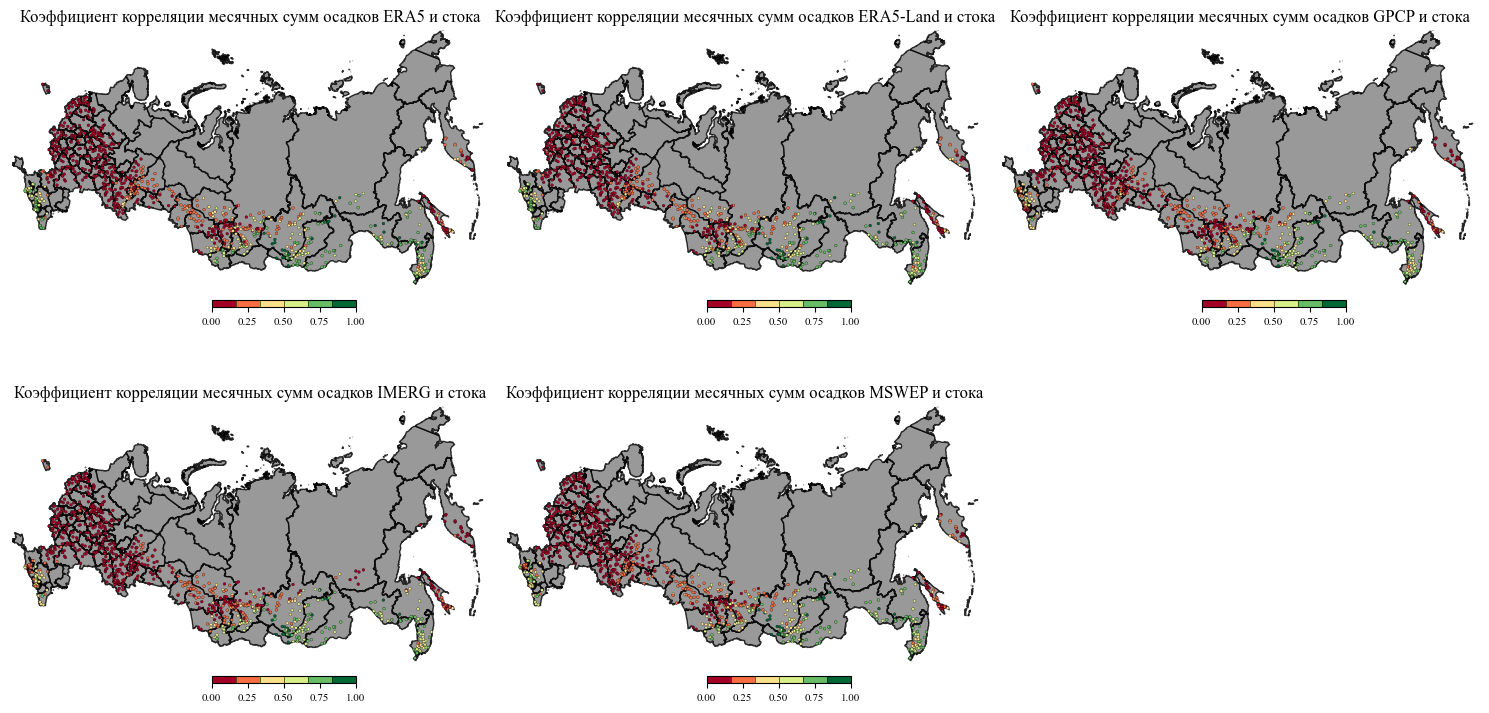

In [61]:
r2_plots_30d = russia_plots_n(
    gdf_to_plot=geom_r2,
    basemap_data=basemap_data,
    figsize=(15, 8),
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                      'prcp_gpcp', 'prcp_imerg',
                      'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции месячных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции месячных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции месячных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции месячных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции месячных сумм осадков MSWEP и стока'])
r2_plots_30d.savefig('./images/r2_plots_30d.png',
                     dpi=650, bbox_inches='tight')

In [185]:
# lstm era5l
lstm_era5l, nse_era5l = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# lstm era5
lstm_era5, nse_era5 = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5_SmallMedium_1205_112433/test/model_epoch021/test_metrics.csv',
                                    metric_col='NSE',
                                    gauges_file=gauges_file)
# lstm gpcp
lstm_gpcp, nse_gpcp = metric_viewer(metric_csv='../test_meteo_input/runs_static/gpcp_SmallMedium_1205_054740/test/model_epoch030/test_metrics.csv',
                                         metric_col='NSE',
                                         gauges_file=gauges_file)
# lstm imerg
lstm_imerg, nse_imerg = metric_viewer(metric_csv='../test_meteo_input/runs_static/imerg_SmallMedium_1205_085602/test/model_epoch030/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# lstm mswep
lstm_mswep, nse_mswep = metric_viewer(metric_csv='../test_meteo_input/runs_static/mswep_static_SmallMedium_0205_153244/test/model_epoch021/test_metrics.csv',
                                          metric_col='NSE',
                                          gauges_file=gauges_file)
# lstm no static
lstm_no_static, nse_no_static = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                              metric_col='NSE',
                                              gauges_file=gauges_file)

In [262]:
nse_file = gpd.GeoDataFrame(geometry=lstm_era5['geometry'])
nse_file.index = lstm_era5.index
nse_file[['name_ru', 'name_en']] = lstm_era5[['name_ru', 'name_en']]
nse_file['NSE_era5l'] = lstm_era5l['NSE']
nse_file['NSE_era5'] = lstm_era5['NSE']
nse_file['NSE_gpcp'] = lstm_gpcp['NSE']
nse_file['NSE_imerg'] = lstm_imerg['NSE']
nse_file['NSE_mswep'] = lstm_mswep['NSE']
nse_file['NSE_no_static'] = lstm_no_static['NSE']
# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
          'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = nse_file[
              ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
               'NSE_imerg', 'NSE_mswep', 'NSE_no_static']].clip(lower=0)

In [256]:
for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                     'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = ugms_part[['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                                                                              'NSE_imerg', 'NSE_mswep', 'NSE_no_static']].median()
ugms_shp.loc[[25, 26, 27], ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                     'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = np.NaN

A Jupyter Widget

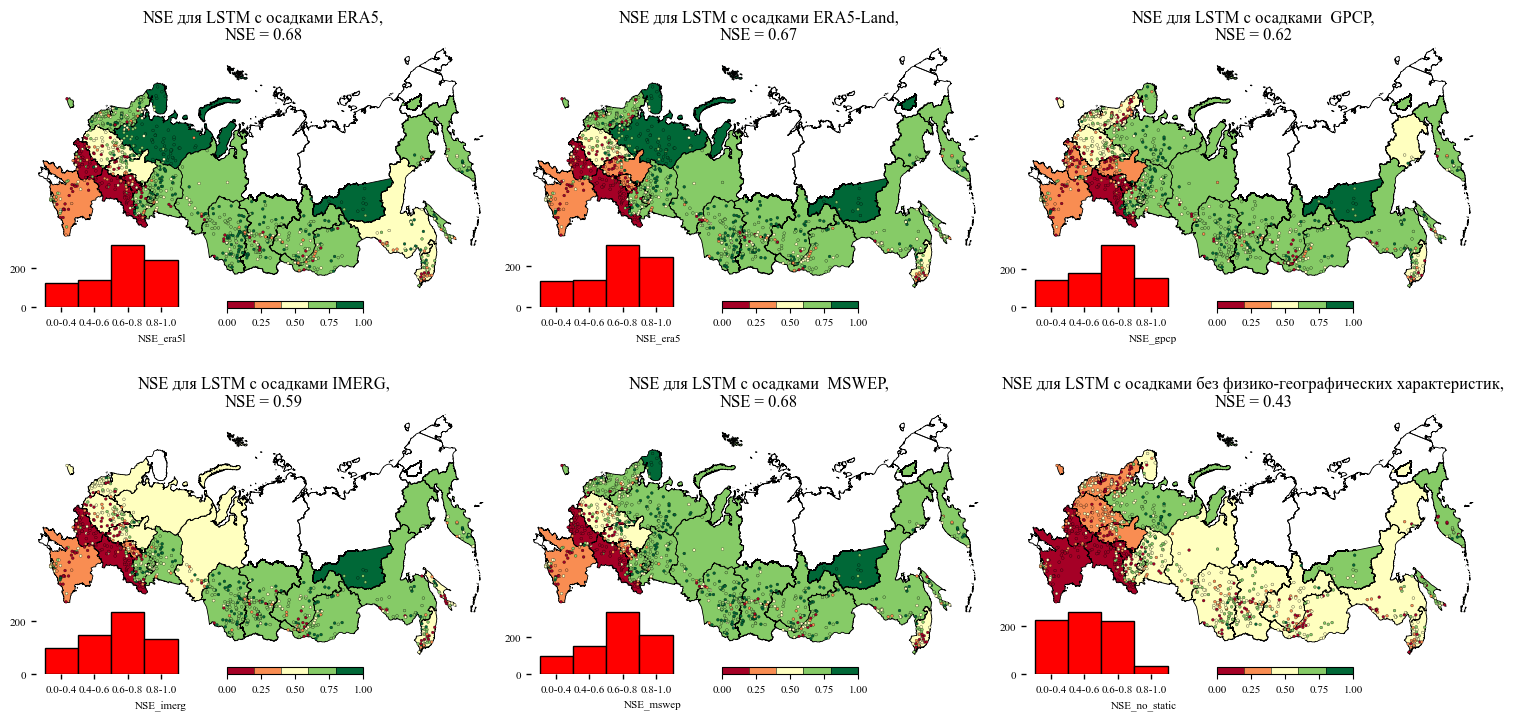

In [263]:
meteo_nse = russia_plots_n(gdf_to_plot=nse_file,
                           basemap_data=basemap_data,
                           figsize=(15, 8),
                           nrows=2,
                           ncols=3,
                           list_of_limits=[0.0, 0.4, 0.6, 0.8, 1.0],
                           columns_from_gdf=['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                                             'NSE_imerg', 'NSE_mswep', 'NSE_no_static'],
                           with_histogram=True, title_text=[f'NSE для LSTM с осадками ERA5,\nNSE = {nse_era5:.2f}',
                                                            f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_era5l:.2f}',
                                                            f'NSE для LSTM с осадками  GPCP,\nNSE = {nse_gpcp:.2f}',
                                                            f'NSE для LSTM с осадками IMERG,\nNSE = {nse_imerg:.2f}',
                                                            f'NSE для LSTM с осадками  MSWEP,\nNSE = {nse_mswep:.2f}',
                                                            f'NSE для LSTM с осадками без физико-географических характеристик,\nNSE = {nse_no_static:.2f}'],
                           ugms=True, ugms_gdf=ugms_shp)
meteo_nse.savefig('./images/meteo_nse.png',
                  dpi=650, bbox_inches='tight')

### Spatial distribution of NSE quality

In [7]:
# tft era5l
lstm_era5l, nse_era5l = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# tft single era5l
tft_era5l, nse_tft = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# tft single era5l
tft_all_era5l, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
# hbv era5l
hbv_era5l, nse_hbv = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j era5l
gr4j_era5l, nse_gr4j = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# rfr era5l
rfr_era5l, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
nse_file = gpd.GeoDataFrame(geometry=lstm_era5l['geometry'])
nse_file.index = lstm_era5l.index
nse_file[['name_ru', 'name_en']] = lstm_era5l[['name_ru', 'name_en']]
nse_file['NSE_era5l'] = lstm_era5l['NSE']
nse_file['NSE_TFT'] = tft_era5l['NSE']
nse_file['NSE_TFT_all'] = tft_all_era5l['NSE']
nse_file['NSE_hbv'] = hbv_era5l['NSE']
nse_file['NSE_gr4j'] = gr4j_era5l['NSE']
nse_file['NSE_rfr'] = rfr_era5l['NSE']
# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
          'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = nse_file[
              ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
               'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']].clip(lower=0)

for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = ugms_part[['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                                                                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']].median()
ugms_shp.loc[[25, 26, 27], ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = np.NaN

A Jupyter Widget

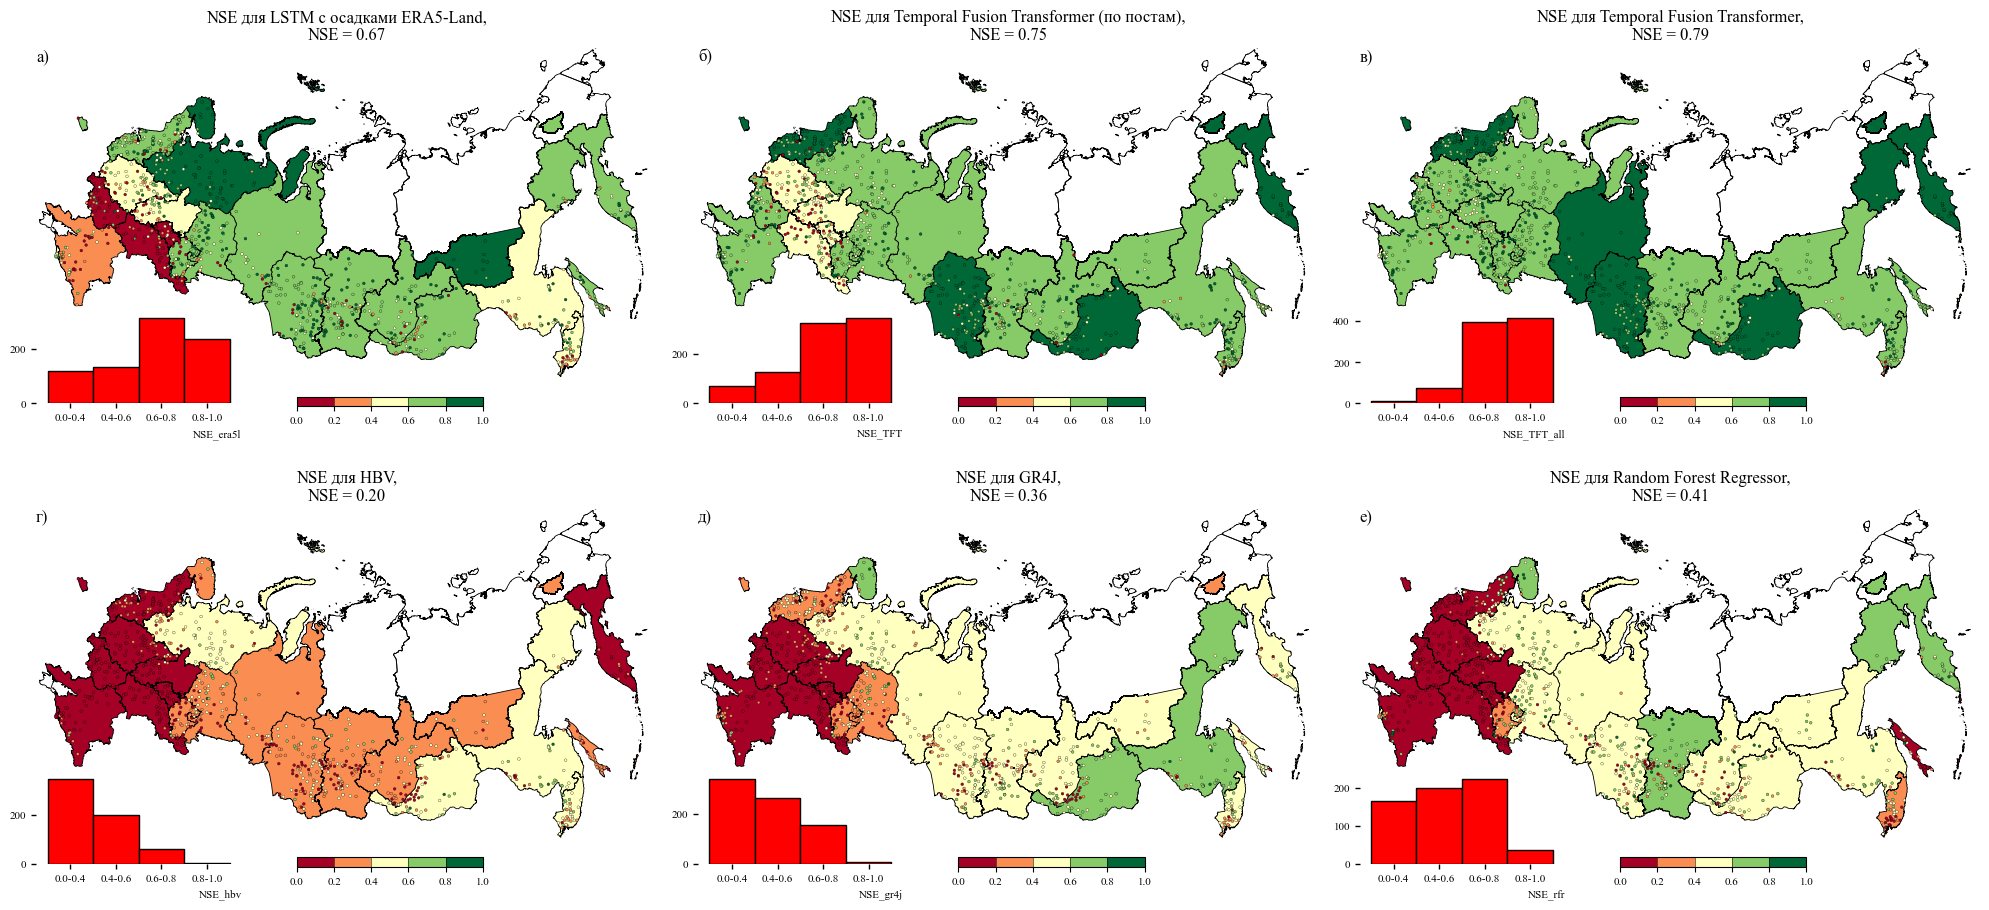

In [271]:
differ_models = russia_plots_n(gdf_to_plot=nse_file,
               basemap_data=basemap_data,
               figsize=(20, 10),
               nrows=2,
               ncols=3,
               columns_from_gdf=['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                                 'NSE_hbv', 'NSE_gr4j', 'NSE_rfr'],
               label_list=['а)', 'б)', 'в)', 'г)', 'д)', 'е)'],
               with_histogram=True, title_text=[f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_era5l:.2f}',
                                                f'NSE для Temporal Fusion Transformer (по постам),\nNSE = {nse_tft:.2f}',
                                                f'NSE для Temporal Fusion Transformer,\nNSE = {nse_tft_all:.2f}',
                                                f'NSE для HBV,\nNSE = {nse_hbv:.2f}',
                                                f'NSE для GR4J,\nNSE = {nse_gr4j:.2f}',
                                                f'NSE для Random Forest Regressor,\nNSE = {nse_rfr:.2f}'],
               ugms=True, ugms_gdf=ugms_shp);
differ_models.savefig('./images/differ_models.png',
                      dpi=650, bbox_inches='tight')

### TFT attributs (feature importance, attention, etc.)

In [278]:
len(tft_era5l['static'].unique())

19

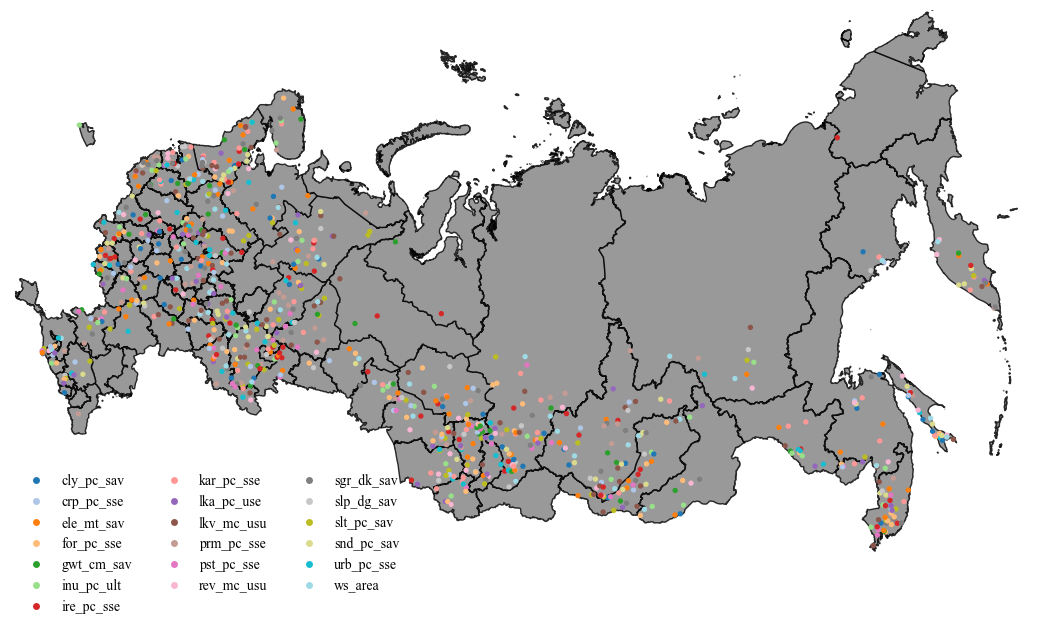

In [285]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='static',
                          cmap_name='tab20',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/static_TFT.png',
                   dpi=650, bbox_inches='tight')

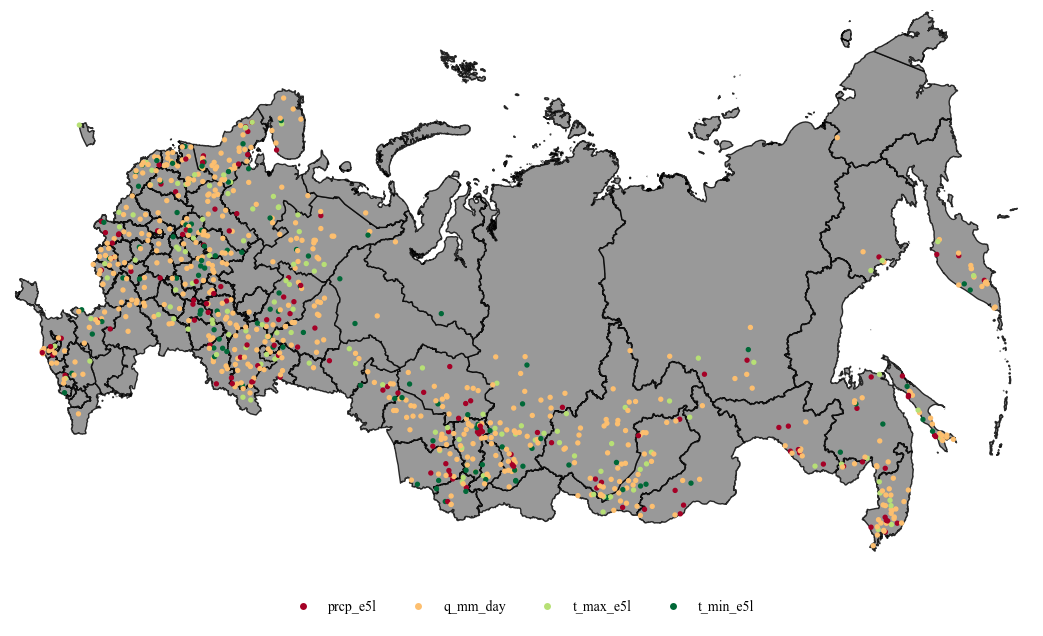

In [291]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='encoder',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/encoder_TFT.png',
                   dpi=650, bbox_inches='tight')

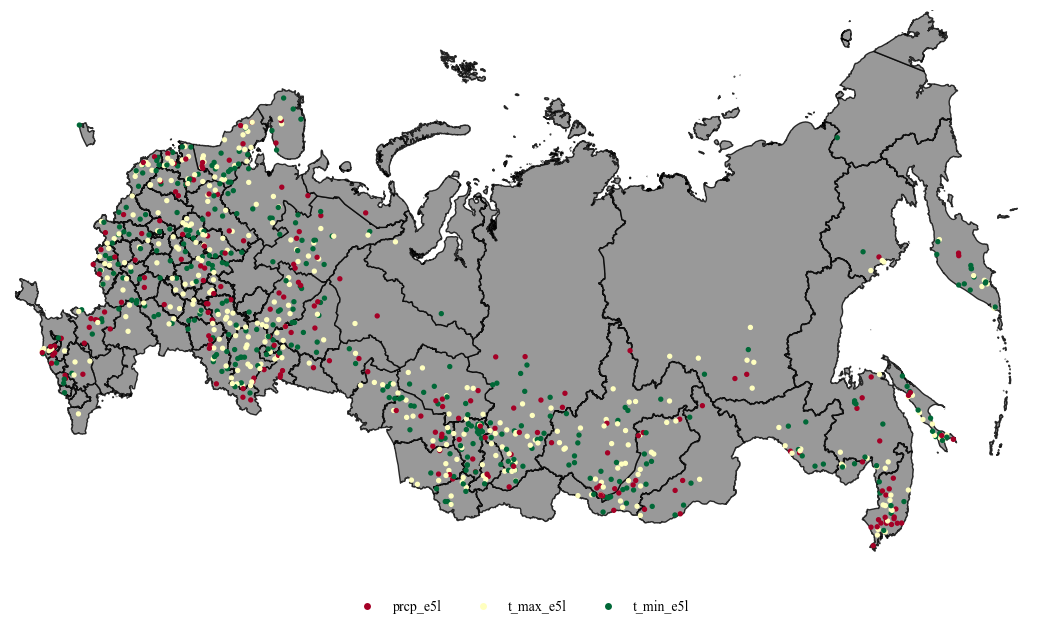

In [293]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='decoder',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/decoder_TFT.png',
                   dpi=650, bbox_inches='tight')

In [294]:
def day_to_attnt(val: float):
    if val < 7:
        return 'Быстряя'
    elif (val >= 7) & (val <= 30):
        return 'Средняя'
    elif (val >= 30) & (val <= 90):
        return 'Средне-длинная'
    else:
        return 'Длинная'
tft_era5l['attention'] = tft_era5l['day'].apply(lambda x: day_to_attnt(x))

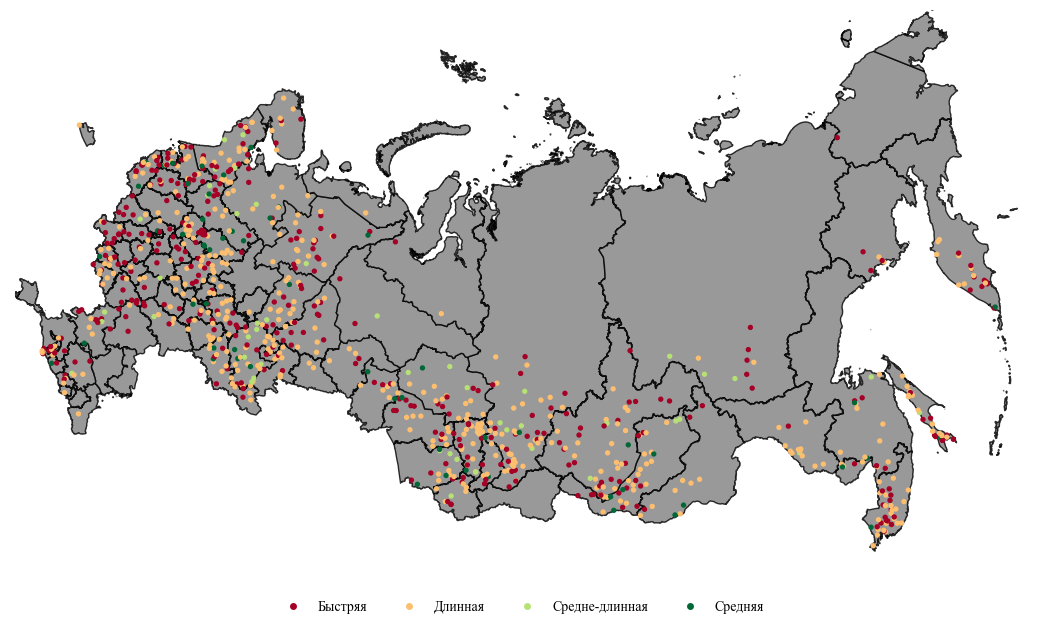

In [296]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='attention',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/attention_TFT.png',
                   dpi=650, bbox_inches='tight')

### GMC forecast quality

In [297]:
def find_gmc(predictions: np.ndarray, observations: np.ndarray,
             days_shift: int, eq_param: int, with_p=False) -> np.ndarray:
    """[summary]

    Args:
        predictions (np.array): [description]
        observations (np.array): [description]
        days_shift (int): [description]

    Returns:
        np.array: [description]
    """

    predictions_error = np.array(observations - predictions)
    delta_1 = np.array(observations[:-days_shift]-observations[days_shift:])
    sigma = np.std(delta_1-np.mean(delta_1), ddof=1)
    gmc_criteria = np.abs(0.674*sigma)
    S = np.sqrt(np.sum([i**2 for i in predictions_error]) /
                (len(predictions_error)-eq_param))

    S_sigma = S/sigma

    descision = ['Прогноз оправдывается' if np.abs(error) <= gmc_criteria
                 else 'Прогноз не оправдывается'
                 for error in predictions_error]

    values, counts = np.unique(descision, return_counts=True)
    try:
        first_value, second_value = counts
        first_key, second_key = values
        print(f'\nКачество прогноза заблаговременностью {days_shift} день')
        print(
            f'''Результаты оценки качества прогноза:\n{first_key} -- {first_value} раз(а),
    {second_key} -- {second_value} раз(а)''')
        print(f'Критерий точности ГМЦ +/- {gmc_criteria:.3f}')
        accuracy = second_value/(first_value + second_value)
        print(f'Оправдываемость прогнозов по методике ГМЦ {accuracy:.2%}')
        print(
            f'S/sigma_delta {S_sigma:.2f} -- длина ряда {len(predictions_error)}')
    except:
        print(f'\nКачество прогноза заблаговременностью {days_shift} день')
        print(
            f'''Результаты оценки качества прогноза:\n{values[0]} -- {counts[0]} раз(а)''')
        print(f'Критерий точности ГМЦ +/- {gmc_criteria:.3f}')
        accuracy = 0
        print(f'Оправдываемость прогнозов по методике ГМЦ {accuracy:.2%}')
        print(
            f'S/sigma_delta {S_sigma:.2f} -- длина ряда {len(predictions_error)}')
    if with_p:
        return np.array([np.round(S*100, decimals=1),
                         np.round(sigma*100, decimals=1),
                         np.round(S_sigma, decimals=2),
                         f'{accuracy:.1%}'])

    else:
        return np.array([np.round(gmc_criteria, decimals=3),
                         np.round(accuracy*100, decimals=2)])

In [299]:
for gauge_id in tft_era5l.index:
    test_df = pd.read_csv(f'./results/tft_single/{gauge_id}.csv',
                      index_col='date')
    test_df.index = pd.to_datetime(test_df.index)
    tft_era5l.loc[gauge_id, 'ГМЦ'] = find_gmc(
        predictions=test_df['q_mm_day_pred'].to_numpy(),
        observations=test_df['q_mm_day'].to_numpy(),
        days_shift=7, eq_param=24, with_p=False)[1]


Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 37 раз(а),
    Прогноз оправдывается -- 688 раз(а)
Критерий точности ГМЦ +/- 0.334
Оправдываемость прогнозов по методике ГМЦ 94.90%
S/sigma_delta 0.43 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 122 раз(а),
    Прогноз оправдывается -- 603 раз(а)
Критерий точности ГМЦ +/- 0.552
Оправдываемость прогнозов по методике ГМЦ 83.17%
S/sigma_delta 0.52 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 112 раз(а),
    Прогноз оправдывается -- 613 раз(а)
Критерий точности ГМЦ +/- 0.422
Оправдываемость прогнозов по методике ГМЦ 84.55%
S/sigma_delta 0.75 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 60 раз(а),
    Прогноз оправдывается -- 665 раз

In [301]:
for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = tft_era5l.loc[[geom.intersects(gage_point)
                              for gage_point in tft_era5l['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['ГМЦ']] = ugms_part[['ГМЦ']].median()
ugms_shp.loc[[25, 26, 27], ['ГМЦ']] = np.NaN

A Jupyter Widget

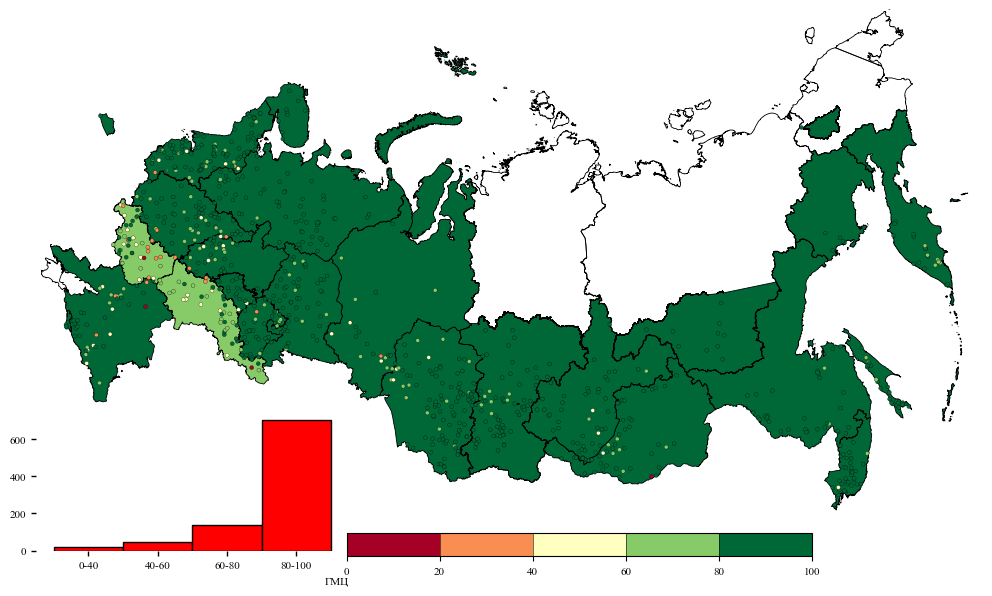

In [311]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='',
                          list_of_limits=[0, 40, 60, 80, 100],
                          figsize=(15, 8),
                          title_text='',
                          with_histogram=True,
                          ugms=True, ugms_gdf=ugms_shp, metric_col='ГМЦ')
gauges_fig.savefig('./images/GMC_tft.png',
                   dpi=650, bbox_inches='tight')

In [366]:
test_df = pd.read_csv('./results/tft_single/10044.csv',
                      index_col='date')
test_df.index = pd.to_datetime(test_df.index)
test_df

q_mm_day  q_mm_day_pred
date                               
2019-01-01  0.229353       0.256738
2019-01-02  0.223678       0.231382
2019-01-03  0.218002       0.239144
2019-01-04  0.212327       0.235815
2019-01-05  0.206652       0.251356
...              ...            ...
2020-12-21  0.360555       0.348478
2020-12-22  0.353878       0.347604
2020-12-23  0.347201       0.372509
2020-12-24  0.340524       0.432434
2020-12-25  0.331511       0.468575

[725 rows x 2 columns]

In [312]:
def lim_definer(area: float):

    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return '< 100 $км^2$'
    elif (area >= lim_1) & (area <= lim_2):
        return '100 $км^2$ - 2 000 $км^2$'
    elif (area > lim_2) & (area <= lim_3):
        return '2 000 $км^2$ - 10 000 $км^2$'
    elif (area > lim_3) & (area <= lim_4):
        return '10 000 $км^2$ - 50 000 $км^2$'
    else:
        return '> 50 000 $км^2$'

ws_file['size'] = ws_file.loc[:, 'new_area'].apply(lambda x: lim_definer(x))
ws_file['size'] = pd.Categorical(ws_file['size'],
                                 ['< 100 $км^2$',
                                  '100 $км^2$ - 2 000 $км^2$',
                                  '2 000 $км^2$ - 10 000 $км^2$',
                                  '10 000 $км^2$ - 50 000 $км^2$'])
ws_file = ws_file.loc[tft_era5l.index, :]

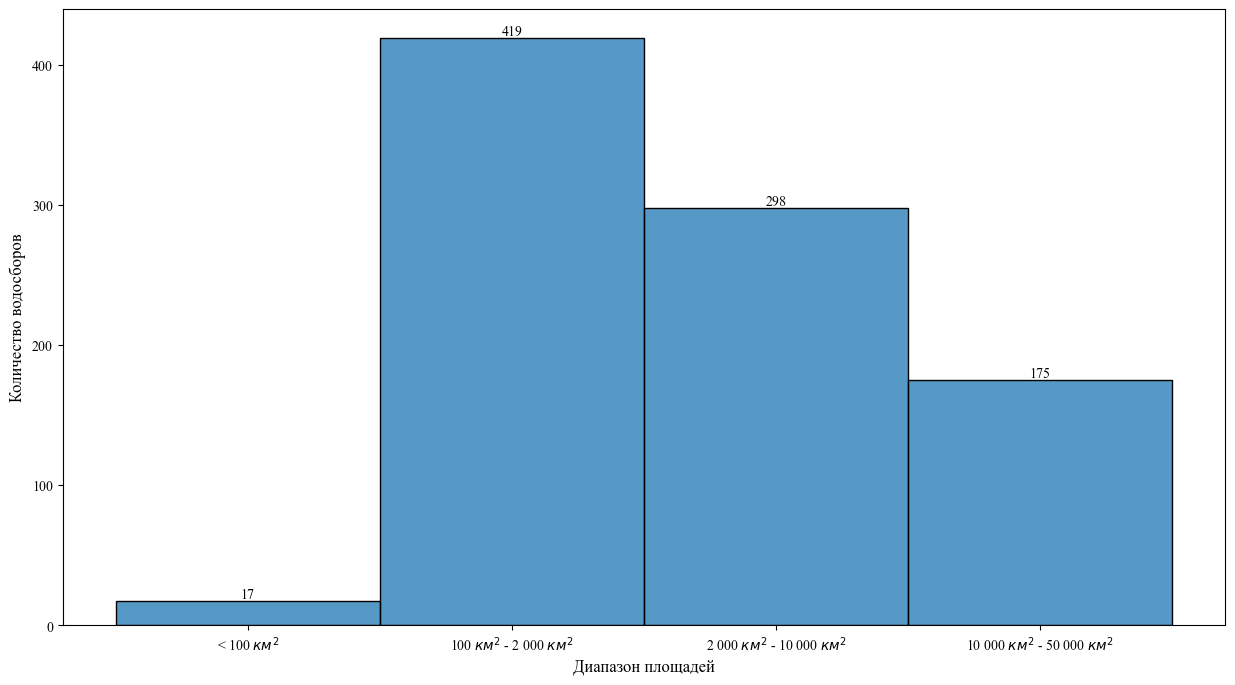

In [317]:

plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(15, 8))

area_hist = sns.histplot(data=ws_file,
                         x='size')
#  set the ticks first
area_hist.set_yticks(np.arange(0, 500, 100));
# set the labels
area_hist.set_yticklabels(np.arange(0, 500, 100));
area_hist.set_xlabel('Диапазон площадей', fontsize=12)
area_hist.set_ylabel('Количество водосборов', fontsize=12)
area_hist.bar_label(area_hist.containers[1], fmt='%.0f')

# area_hist.set_title(f"""Распределение водосборов по площадям""", fontsize=12);
plt.savefig('./images/area_distribution.png',
            dpi=650, bbox_inches='tight')

In [333]:
stat_nse_qual = pd.DataFrame()

for i, (stat_attr, indx) in enumerate(
    tft_era5l.groupby('static').groups.items()):
    
    stat_nse_qual.loc[i, 'Физико-географический атрибут'] = stat_attr
    stat_nse_qual.loc[i, 'NSE'] = tft_era5l.loc[indx, 'NSE'].mean()
    

In [335]:
stat_nse_qual

Физико-географический атрибут       NSE
0                     cly_pc_sav  0.547012
1                     crp_pc_sse  0.380154
2                     ele_mt_sav  0.636396
3                     for_pc_sse  0.685875
4                     gwt_cm_sav  0.624563
5                     inu_pc_ult  0.654382
6                     ire_pc_sse  0.556711
7                     kar_pc_sse  0.708467
8                     lka_pc_use  0.686307
9                     lkv_mc_usu  0.572746
10                    prm_pc_sse  0.635245
11                    pst_pc_sse  0.610373
12                    rev_mc_usu  0.679000
13                    sgr_dk_sav  0.710811
14                    slp_dg_sav  0.695742
15                    slt_pc_sav  0.701114
16                    snd_pc_sav  0.433128
17                    urb_pc_sse -2.120386
18                       ws_area  0.510478

In [318]:
ws_file['NSE'] = tft_era5l['NSE']
ws_file['ГМЦ'] = tft_era5l['ГМЦ']

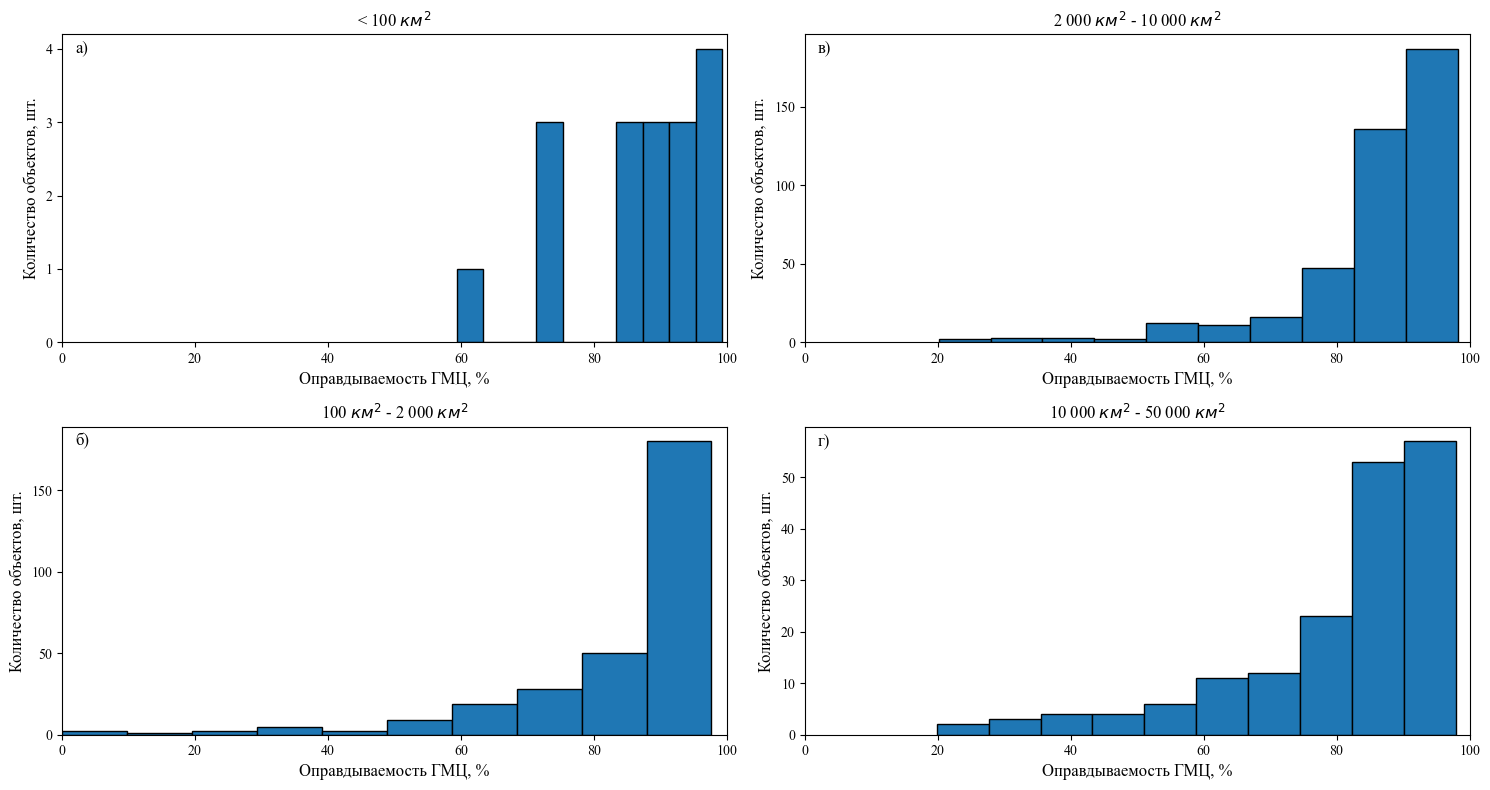

In [338]:
my_hist = ws_file.hist(column='ГМЦ',
                       by='size',
                       figsize=(15, 8),
                       edgecolor='black', linewidth=1)

xlbl = [str(col).replace(', ', '-')
        for col in np.unique(ws_file['size'])]
label_list = ['а)', 'в)', 'б)', 'г)'][::-1]

for i, ax in enumerate(my_hist.flatten()[::-1]):
    ax.set_title(xlbl[i])
    ax.text(.02, .98, label_list[i], ha='left', va='top',
        transform=ax.transAxes, fontsize=12)
    ax.set_xlabel("Оправдываемость ГМЦ, %", fontsize=12)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.set_ylabel('Количество объектов, шт.', fontsize=12)
    ax.locator_params(axis='y', nbins=7)
    ax.set_xlim((0, 100))
    ax.locator_params(axis='x', nbins=5)
    ax.tick_params(axis='x', labelrotation=0);
plt.tight_layout()
plt.savefig('./images/gmc_distribution.png',
            dpi=650, bbox_inches='tight')


In [525]:
def nse_descriptor(nse_df: pd.DataFrame,
                   model_name: str):
    res_df = pd.DataFrame()
    res_df.loc[0, 'Модель'] = model_name
    
    res_df.loc[0, 'Объектов в выборке'] = f'{len(nse_df):.0f}'
    
    nse_max = nse_df['NSE'].max()
    res_df.loc[0, 'Максимум NSE'] = f'{nse_max:.2f}'
    
    nse_median = nse_df['NSE'].median()
    res_df.loc[0, 'Медианный NSE'] = f'{nse_median:.2f}'
    
    nse_mean = nse_df['NSE'].mean()
    res_df.loc[0, 'Средний NSE'] = f'{nse_mean:.2f}'
    
    nse_min = nse_df['NSE'].min()
    res_df.loc[0, 'Минимум NSE'] = f'{nse_min:.2f}'
    
    nse_less_t_z = (nse_df['NSE'] < 0).sum()
    res_df.loc[0, 'NSE < 0'] = f'{nse_less_t_z:.0f}'
    
    
    return res_df

In [527]:
from copy import deepcopy
test_gr4j = deepcopy(gr4j_era5l)
test_rfr = deepcopy(rfr_era5l)

for g_id in test_gr4j.index:
    if g_id in ws_file.index:
        pass
    else:
        test_gr4j = test_gr4j.drop(g_id)

for g_id in test_rfr.index:
    if g_id in ws_file.index:
        pass
    else:
        test_rfr = test_rfr.drop(g_id)
res_list = list()
for model, res in {
    'LSTM физ. гео ERA5-Land': lstm_era5l,
    'LSTM физ. гео ERA5': lstm_era5,
    'LSTM физ. гео GPCP': lstm_gpcp,
    'LSTM физ. гео IMERG': lstm_imerg,
    'LSTM физ. гео MSWEP': lstm_mswep,
    'LSTM ERA5-Land без физ. гео': lstm_no_static.loc[ws_file.index, :],
    'Temporal Fusion Transformer (для поста)': tft_era5l,
    'Temporal Fusion Transformer (все посты)': tft_all_era5l,
    'HBV ERA5-Land': hbv_era5l.loc[ws_file.index, :],
    'GR4J ERA5-Land': test_gr4j,
        'RandomForestRegressor ERA5-Land': test_rfr}.items():
    res_list.append(nse_descriptor(nse_df=res, model_name=model))
pd.concat(res_list).sort_values(by='Медианный NSE',
                                ascending=False).reset_index(drop=True).to_csv('./tables/model_quality.csv', index=False)

### q5, q95, mean, baseflow 

In [336]:
from scripts.hydro_metrics import hydro_job
from scripts.processing import split_by_hydro_year, split_by_year

In [532]:
test_df = pd.read_csv('./results/tft_256/10042.csv',
                      index_col='date')
test_df.index = pd.to_datetime(test_df.index)

In [561]:
test_df.columns

Index(['q_mm_day', 'q_mm_day_pred'], dtype='object')

In [337]:
gage_comp = dict()
final_list = list()
for g_id in tqdm(ws_file.index):
    gage_comp[g_id] = dict()
    test_df = pd.read_csv(f'./results/tft_256/{g_id}.csv',
                      index_col='date')
    test_df.index = pd.to_datetime(test_df.index)
    for col in test_df.columns:
        year_res = list()
        hydro_years = split_by_hydro_year(test_df[col])
        calendar_years = split_by_year(test_df[col])

        for year in hydro_years.keys():
            year_res.append(pd.DataFrame(hydro_job(hydro_year=hydro_years[year],
                                                   calendar_year=calendar_years[year]),
                                         index=[0]))
        year_res = pd.concat(year_res)
        gage_comp[g_id][col] = year_res
    res_df = (gage_comp[g_id]['q_mm_day'] - gage_comp[g_id]
              ['q_mm_day_pred'])/gage_comp[g_id]['q_mm_day'] * 100
    res_df = res_df.mean().to_frame().T
    res_df['gauge_id'] = g_id
    final_list.append(res_df)
tft_stats = pd.concat(final_list).set_index('gauge_id', drop=True)

A Jupyter Widget

In [339]:
tft_era5l[['mean', 'bfi', 'q5', 'q95']] = tft_stats

In [340]:
tft_stats.mean()

mean   -14.390340
bfi     -5.275942
q5     -11.874552
q95     39.252894
dtype: float64

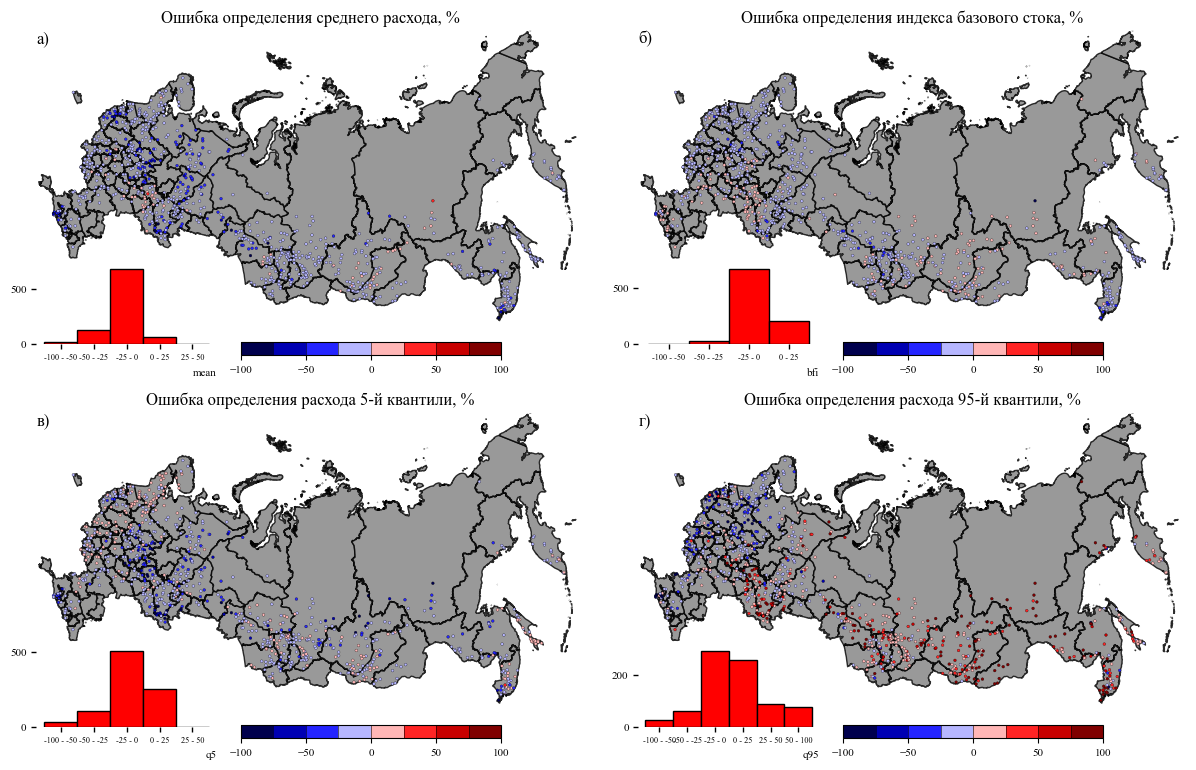

In [349]:
russia_plots_n(gdf_to_plot=tft_era5l,
               basemap_data=basemap_data,
               cmap_name='seismic',
               figsize=(15, 8),
               list_of_limits=[-100, -50, -25, 0, 25, 50, 100],
               label_list= ['а)', 'б)', 'в)', 'г)'],
               nrows=2,
               ncols=2,
               columns_from_gdf=['mean', 'bfi', 'q5', 'q95'],
               with_histogram=True, title_text=[f'Ошибка определения среднего расхода, %',
                                                f'Ошибка определения индекса базового стока, %',
                                                f'Ошибка определения расхода 5-й квантили, %',
                                                f'Ошибка определения расхода 95-й квантили, %']);
plt.savefig('./images/q5q95bfimean.png',
            dpi=650, bbox_inches='tight')

### Static parameters description

In [12]:
static_params = pd.read_csv('../geo_data/attributes/geo_vector.csv')
static_params = static_params.set_index('gauge_id')
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']
static_final = static_params[static_parameters]

test_static = deepcopy(static_final)

In [ ]:

for g_id in test_static.index:
    if str(g_id) in tft_era5l.index:
        pass
    else:
        test_static = test_static.drop(g_id)
        
test_static_big = deepcopy(static_params)
for g_id in test_static_big.index:
    if str(g_id) in tft_era5l.index:
        pass
    else:
        test_static_big = test_static_big.drop(g_id)

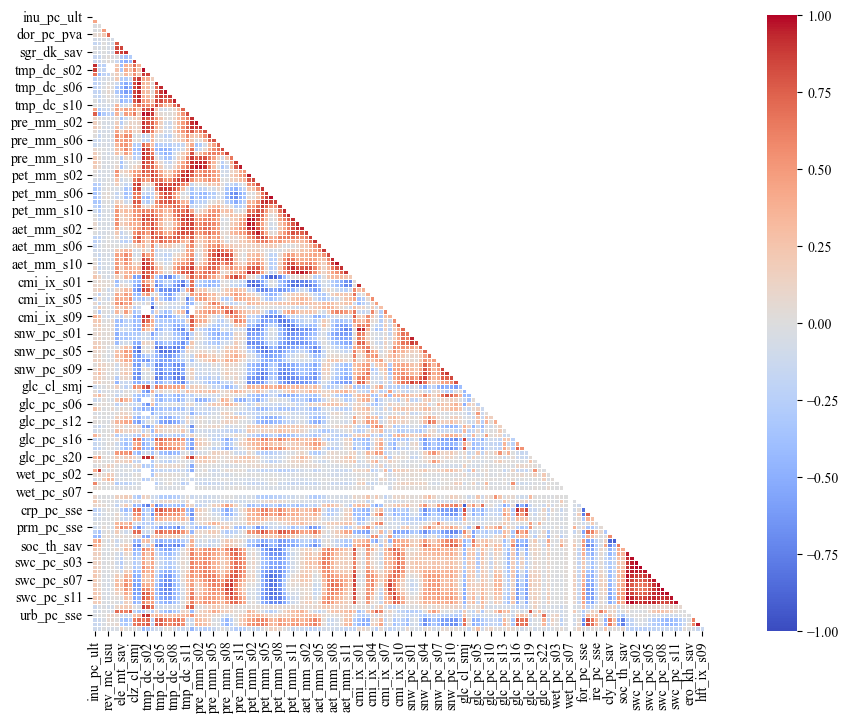

In [352]:
plt.rcParams["font.family"] = "Times New Roman"
# remove columns which had no representation in data
corr_frame = test_static_big.drop(['glc_pc_s01', 'glc_pc_s03',
                                   'glc_pc_s07', 'glc_pc_s08',
                                   'wet_pc_s05'], axis=1)
correlation_matrix = corr_frame.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 1});
plt.savefig('./images/corr_mat_everything.png',
            dpi=650, bbox_inches='tight')


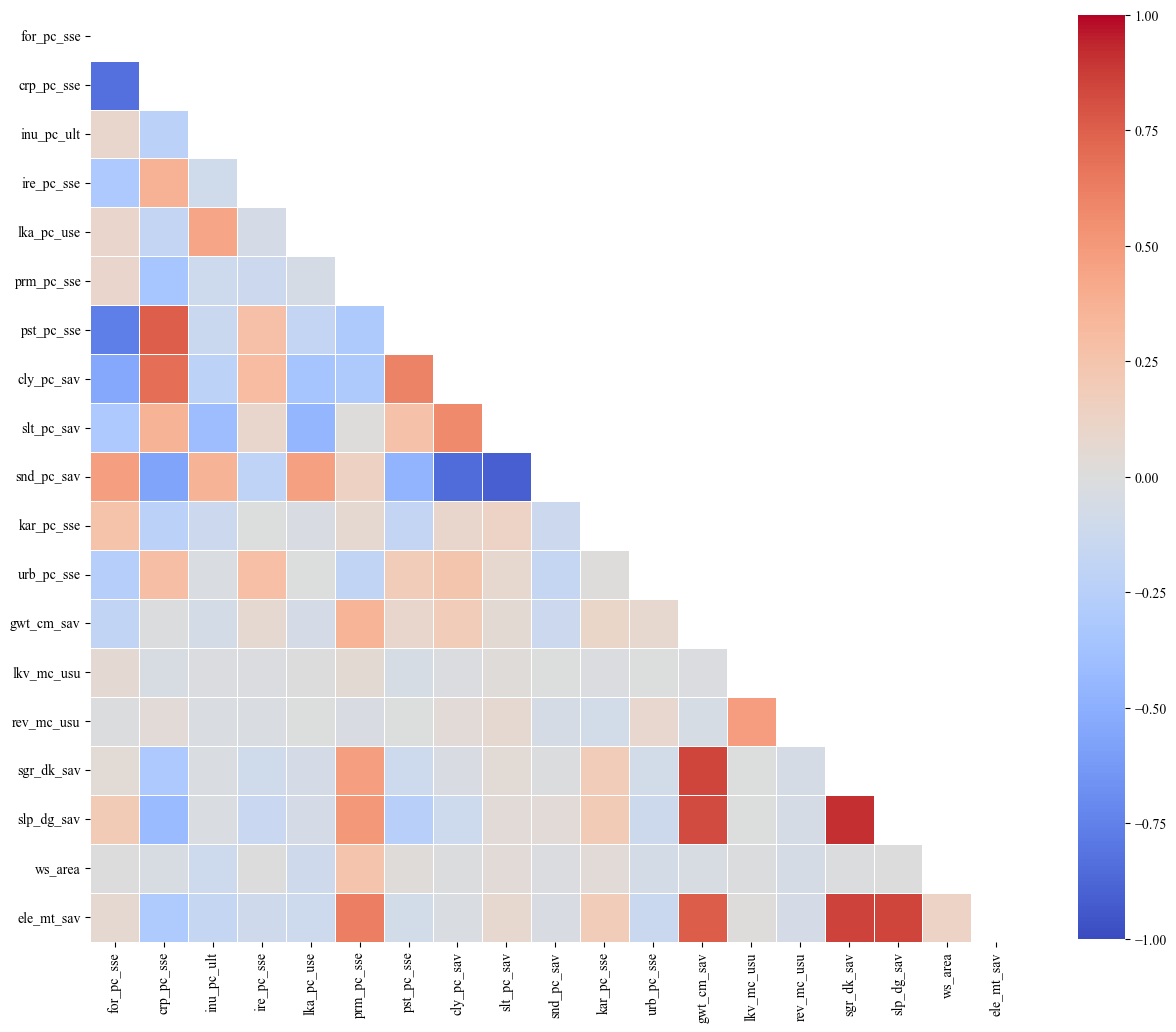

In [354]:
# remove columns which had no representation in data
correlation_matrix = test_static.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8});
plt.savefig('./images/corr_mat_final.png',
            dpi=650, bbox_inches='tight')


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

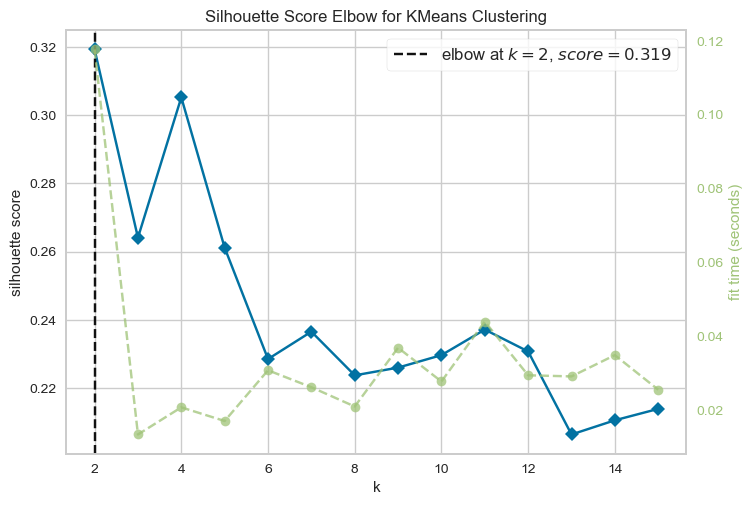

In [20]:
km = KMeans(n_init=6)
Elbow_M = KElbowVisualizer(estimator = km, k = 15, metric='silhouette')
Elbow_M.fit(test_static)
Elbow_M.show()

plt.show()

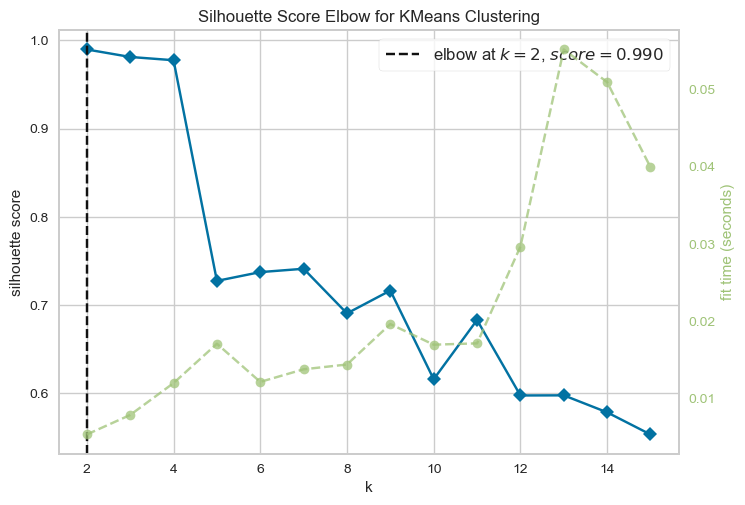

In [385]:
km = KMeans(n_init=6)
Elbow_M = KElbowVisualizer(estimator = km, k = 15, metric='silhouette')
Elbow_M.fit(test_static.to_numpy())
Elbow_M.show()


def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42, n_init=6)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results,
                          columns=["Количество кластеров", "Величина силуэта"])
    pivot_km = pd.pivot_table(result,
                              index="Количество кластеров",
                              values="Величина силуэта")
    pivot_km = pivot_km.rename(columns={"Величина силуэта": ''})

    fig = plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_km, annot=True, linewidths=1,
                fmt='.3f', cmap='RdYlGn', cbar=False)

    plt.tight_layout()
    plt.ylabel('Количество кластеров, шт.', fontsize=12)
    plt.xlabel('Величина "силуэта"', fontsize=12)
    plt.show()
    
    return fig, pivot_km

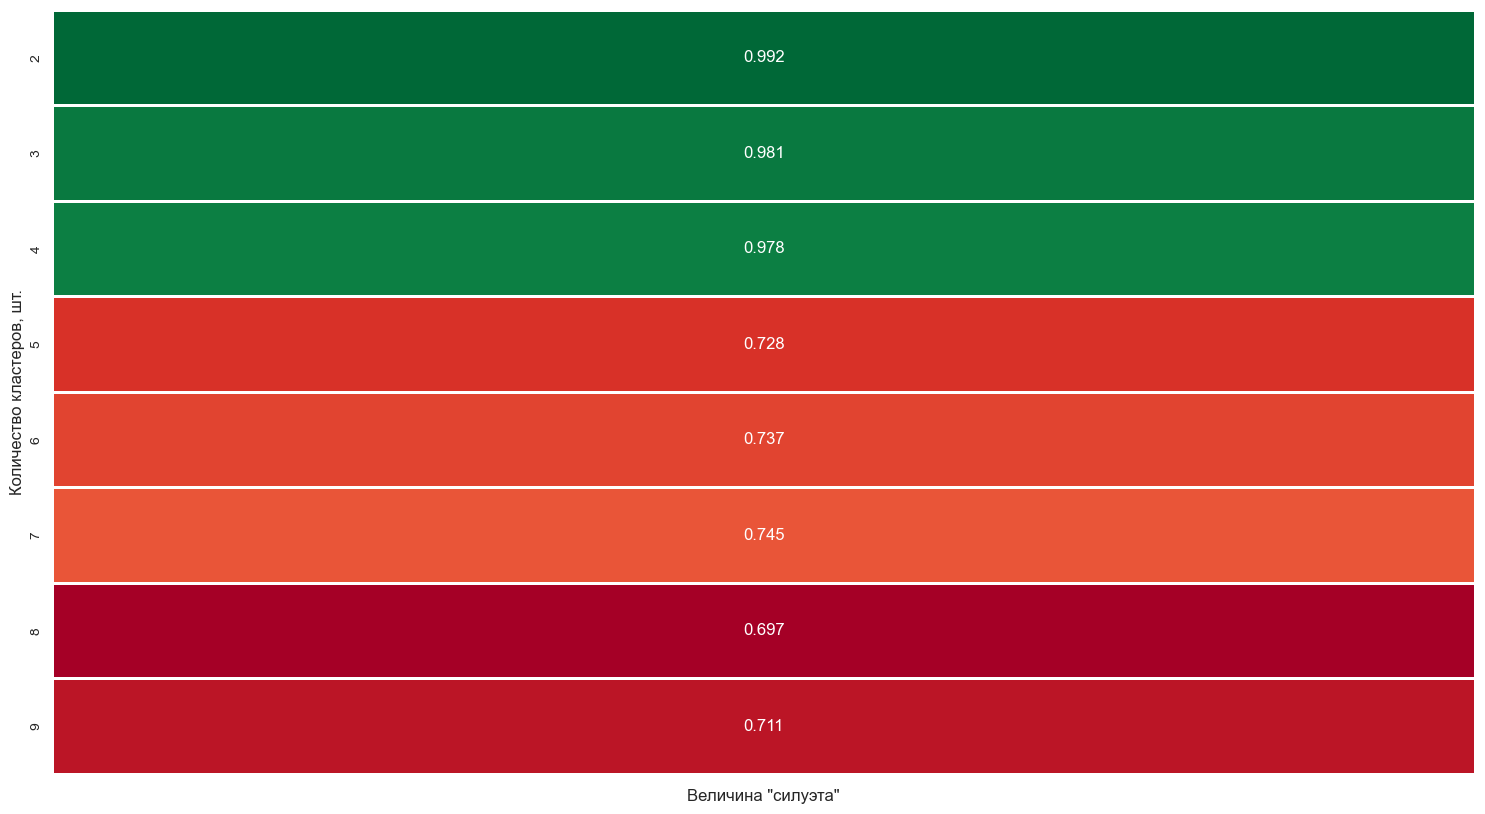

In [386]:
sil_fig, table = visualize_silhouette_layer(test_static.to_numpy())
sil_fig.savefig('./images/clusters_number.png',
                dpi=650, bbox_inches='tight')

In [14]:
test_static.index = test_static.index.astype(str)
test_static = test_static.loc[tft_era5l.index, :]

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

test_static = test_static.loc[tft_era5l.index, :]
def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


km = KMeans(n_clusters=4, random_state=42, n_init=100)

yhat_AC = km.fit_predict(pca95(test_static))

tft_era5l['Кластер'] = [str(f'Кластер {i+1}')for i in yhat_AC]
test_static['ResClust'] = [i+1 for i in yhat_AC]

NameError: name 'KMeans' is not defined

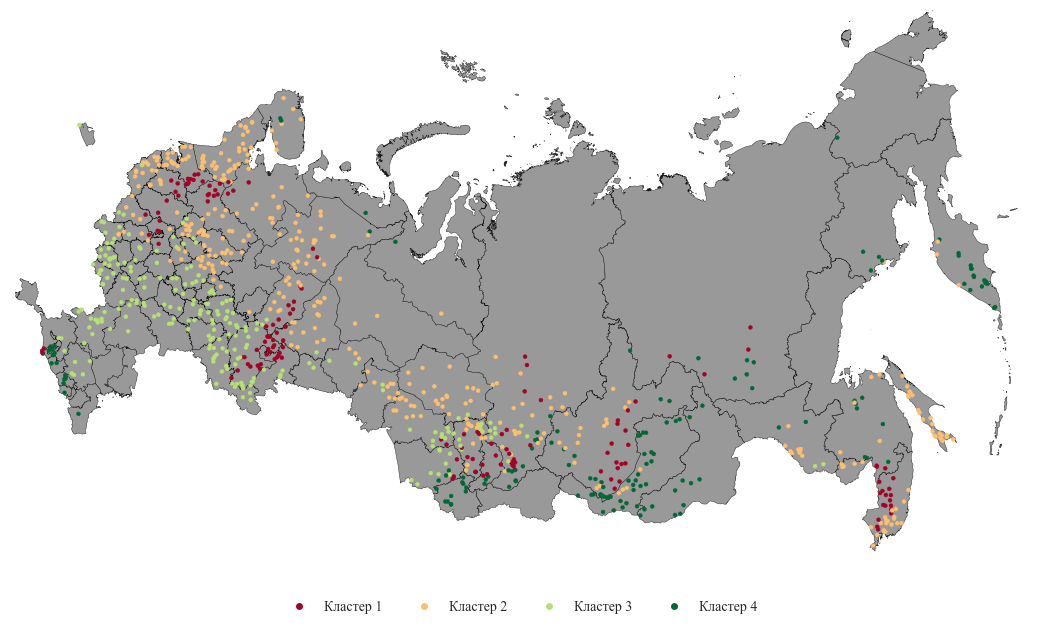

In [52]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='Кластер',
                        #   metric_col='Кластер',
                          list_of_limits=[0, 1, 2, 3, 4],
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)
gauges_fig.savefig('./images/clusters_Rus.png',
                   dpi=650, bbox_inches='tight')

In [16]:
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [17]:
from matplotlib import cm
import matplotlib as mpl
cmap_name: str = 'RdYlGn'
cmap = cm.get_cmap(cmap_name, 4)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

In [21]:
test_static = test_static.loc[tft_era5l.index, :]
def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df

test_static.loc[:, :] = MinMaxScaler().fit_transform(test_static.values)
km = KMeans(n_clusters=4, random_state=42, n_init=100)

yhat_AC = km.fit_predict(pca95(test_static))

tft_era5l['Кластер'] = [str(f'Кластер {i+1}')for i in yhat_AC]
test_static['ResClust'] = [i+1 for i in yhat_AC]
# test_static['color'] = test_static['ResClust'].apply(
    # lambda x: dict(zip([1, 2, 3, 4], color_list))[x])

In [33]:
polar = test_static.groupby('ResClust').mean().reset_index()

polar = pd.melt(polar, id_vars=['ResClust'])


fig_polar = px.line_polar(polar, r='value', theta='variable',
                          color='ResClust', color_discrete_sequence=color_list,
                          template='seaborn', height=800, width=800)
fig_polar.update_layout(
    polar=dict(
        # radialaxis_angle = -45
        radialaxis=dict(showticklabels=False, ticks=''),
        angularaxis=dict(showticklabels=True, tickangle=0)
    ),
    legend_title_text='Кластеры',
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0
    )
)
fig_polar.write_image('./images/cluster_importance.png')


In [34]:
fig_polar